In [134]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import matplotlib
import numpy as np
%matplotlib inline
import pandas as pd
import cv2 as cv
from google.colab.patches import cv2_imshow # for image display in google colab

In [135]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [136]:
mean = np.array([0.5, 0.5, 0.5])
#std = np.array([0.25, 0.25, 0.25])
std = np.array([0.5, 0.5, 0.5])

# transforming the images before feeding to the network

data_transforms = {
    'data': transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])   
}


from google.colab import drive
drive.mount('/content/drive')

import zipfile
data_path = "/content/drive/MyDrive/Colab Notebooks/mask_detection_dataset.zip"
zip_ref = zipfile.ZipFile(data_path, 'r')
zip_ref.extractall("/content")
zip_ref.close()


folder = "/content/dataset"

dataset = datasets.ImageFolder(folder, data_transforms['data'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [137]:
#train_set = torch.utils.data.Subset(dataset, range(int(0.5*len(dataset)), int(0.95*len(dataset))))  # take first 90%
#test_set = torch.utils.data.Subset(dataset, range(int(0.9*len(dataset)), len(dataset)))  # take the rest 10%   

train_set, test_set = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), len(dataset) - int(0.8*len(dataset))])

#hyperparameters
batch_size = 4
num_epochs = 50

data_loader = {}
data_loader['train'] = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
data_loader['test'] = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)

In [138]:
class_names = dataset.classes
print(class_names)

['with mask', 'without mask']


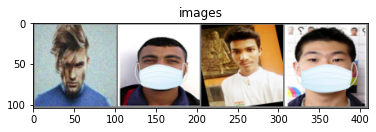

In [139]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

inputs, classes = (iter(data_loader['train'])).next()
out = torchvision.utils.make_grid(inputs)
imshow(out, 'images')

### Training CNN 

In [140]:
class MaskConvNet(nn.Module):
    def __init__(self):
      super(MaskConvNet, self).__init__()

      # input dim (3, 100, 100)
      self.conv_block1 = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(2, 2), stride=(1, 1)),
          #nn.BatchNorm2d(num_features=6),
          nn.ReLU(),                                     
          nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
      )

      # dim (6, 49, 49)
      self.conv_block2 = nn.Sequential(
          nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(3, 3), stride=(1, 1)),
          #nn.BatchNorm2d(num_features=12),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
      )


     
      # dim (12, 23 23)
      self.FC_block1 = nn.Sequential(
          nn.Linear(in_features=12*23*23, out_features=50),
          #nn.BatchNorm1d(num_features=50),
          nn.ReLU(),
          nn.Dropout(p=0.5)
      )


      # dim (1, 50)
      self.softmax_block = nn.Sequential(
          nn.Linear(in_features=50, out_features=2)
      )


    
    def forward(self, x):
      x = self.conv_block1(x)
      x = self.conv_block2(x)
      x = x.view(-1, 12*23*23)
      x = self.FC_block1(x)
      x = self.softmax_block(x)
      return x


In [141]:
torch.manual_seed(1)
np.random.seed(1)

model = MaskConvNet().to(device)

from torchsummary import summary
summary(model.cuda(), (3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 99, 99]              78
              ReLU-2            [-1, 6, 99, 99]               0
         MaxPool2d-3            [-1, 6, 49, 49]               0
            Conv2d-4           [-1, 12, 47, 47]             660
              ReLU-5           [-1, 12, 47, 47]               0
         MaxPool2d-6           [-1, 12, 23, 23]               0
            Linear-7                   [-1, 50]         317,450
              ReLU-8                   [-1, 50]               0
           Dropout-9                   [-1, 50]               0
           Linear-10                    [-1, 2]             102
Total params: 318,290
Trainable params: 318,290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 1.46
Params size (MB): 1.21
Estimated T

In [142]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Training the model

In [143]:
samples = [0 for i in range(2)]
for (images, labels) in data_loader['test']:
  for i in range(labels.shape[0]):
    samples[labels[i]] += 1
  
samples

[145, 131]

In [144]:
model = model.to(device)
startTime = time.time()
training_losses = []

model.train()
for epoch in range(num_epochs):
    
    running_loss = 0
    for i, (images, labels) in enumerate(data_loader['train']):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    training_losses.append(running_loss/(len(data_loader['train'])))
    print (f'Epoch [{epoch+1}/{num_epochs}]  Loss: {loss.item():.4f}')


trainTime = (time.time() - startTime)
print('Finished Training')

Epoch [1/50]  Loss: 0.4271
Epoch [2/50]  Loss: 0.0580
Epoch [3/50]  Loss: 0.0006
Epoch [4/50]  Loss: 0.1141
Epoch [5/50]  Loss: 0.0008
Epoch [6/50]  Loss: 0.0008
Epoch [7/50]  Loss: 0.0053
Epoch [8/50]  Loss: 0.0016
Epoch [9/50]  Loss: 0.0075
Epoch [10/50]  Loss: 0.0002
Epoch [11/50]  Loss: 0.0139
Epoch [12/50]  Loss: 0.0001
Epoch [13/50]  Loss: 0.2058
Epoch [14/50]  Loss: 0.2459
Epoch [15/50]  Loss: 0.0002
Epoch [16/50]  Loss: 0.0000
Epoch [17/50]  Loss: 0.0000
Epoch [18/50]  Loss: 0.0696
Epoch [19/50]  Loss: 0.0000
Epoch [20/50]  Loss: 0.0000
Epoch [21/50]  Loss: 0.0001
Epoch [22/50]  Loss: 0.0002
Epoch [23/50]  Loss: 0.1831
Epoch [24/50]  Loss: 0.0000
Epoch [25/50]  Loss: 0.0000
Epoch [26/50]  Loss: 0.0000
Epoch [27/50]  Loss: 0.0000
Epoch [28/50]  Loss: 0.0005
Epoch [29/50]  Loss: 0.0000
Epoch [30/50]  Loss: 0.0000
Epoch [31/50]  Loss: 0.0043
Epoch [32/50]  Loss: 0.1378
Epoch [33/50]  Loss: 0.0001
Epoch [34/50]  Loss: 0.0000
Epoch [35/50]  Loss: 0.0000
Epoch [36/50]  Loss: 0.0028
E

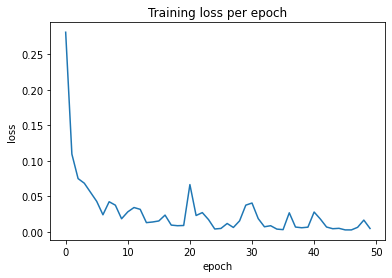

In [145]:
plt.plot(training_losses)
plt.title('Training loss per epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('TrainingLoss_For_maskDetection.jpg')

In [146]:
# Saving the model

PATH = './cnn.pth'
torch.save(model, PATH)
# for loading - torch.load(PATH)

In [147]:

def testing(dataset_type):
  model.eval()
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(2)]
  n_class_samples = [0 for i in range(2)]

  for images, labels in data_loader[dataset_type]:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)

    _, predicted = torch.max(outputs, 1)
    n_samples += labels.shape[0]
    n_correct += (predicted==labels).sum().item()

    for i in range(labels.shape[0]):
      label = labels[i]
      pred = predicted[i]
      if (label==pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1


  accuracy = 100.0*n_correct/n_samples
  print("Accuracy of the network for {0} dataset is {1:.4f}%".format(dataset_type, accuracy))

  for i in range(2):
        accuracy = 100.0 * n_class_correct[i] / (n_class_samples[i]+1e-13)
        print("Accuracy of {0}: {1:.4f}%".format(classes[i], accuracy))

In [148]:
print("Training metrics:\n")
testing('train')
print("\n\nTesting metrics:\n")
testing('test')

print("\nTraining time: {0:.3f} minutes, {1:.3f} seconds".format(trainTime//60, trainTime%60))

Training metrics:

Accuracy of the network for train dataset is 100.0000%
Accuracy of 1: 100.0000%
Accuracy of 0: 100.0000%


Testing metrics:

Accuracy of the network for test dataset is 99.2754%
Accuracy of 1: 99.3103%
Accuracy of 0: 99.2366%

Training time: 4.000 minutes, 15.293 seconds


Training on entire Dataset

In [149]:
data = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

model = MaskConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 100
training_losses = []
model.train()
for epoch in range(num_epochs):
    
    running_loss = 0
    for i, (images, labels) in enumerate(data):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    training_losses.append(running_loss/(len(data)))
    print (f'Epoch [{epoch+1}/{num_epochs}]  Loss: {loss.item():.4f}')


print('Finished Training')

Epoch [1/100]  Loss: 0.3954
Epoch [2/100]  Loss: 0.1782
Epoch [3/100]  Loss: 0.0007
Epoch [4/100]  Loss: 0.9412
Epoch [5/100]  Loss: 0.3516
Epoch [6/100]  Loss: 0.3633
Epoch [7/100]  Loss: 0.0058
Epoch [8/100]  Loss: 0.0000
Epoch [9/100]  Loss: 0.6933
Epoch [10/100]  Loss: 0.2241
Epoch [11/100]  Loss: 0.1759
Epoch [12/100]  Loss: 0.1590
Epoch [13/100]  Loss: 0.3527
Epoch [14/100]  Loss: 0.3389
Epoch [15/100]  Loss: 0.0048
Epoch [16/100]  Loss: 0.0000
Epoch [17/100]  Loss: 0.0295
Epoch [18/100]  Loss: 0.1195
Epoch [19/100]  Loss: 0.0002
Epoch [20/100]  Loss: 0.0001
Epoch [21/100]  Loss: 0.0983
Epoch [22/100]  Loss: 0.0468
Epoch [23/100]  Loss: 0.4422
Epoch [24/100]  Loss: 0.0002
Epoch [25/100]  Loss: 0.2010
Epoch [26/100]  Loss: 0.1861
Epoch [27/100]  Loss: 0.1662
Epoch [28/100]  Loss: 0.1960
Epoch [29/100]  Loss: 0.1739
Epoch [30/100]  Loss: 0.1733
Epoch [31/100]  Loss: 0.0073
Epoch [32/100]  Loss: 0.0015
Epoch [33/100]  Loss: 0.0000
Epoch [34/100]  Loss: 0.1831
Epoch [35/100]  Loss: 0

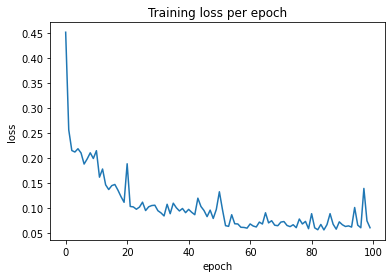

In [150]:
plt.plot(training_losses)
plt.title('Training loss per epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('TrainingLoss_For_maskDetection.jpg')

# Saving the model

PATH = './Mask_CNN.pth'
torch.save(model, PATH)
# for loading - torch.load(PATH)